# Clustering analysis

Hierarchical clustering is performed in an agglomerative manner with Ward's method as the chosen similarity definition. In the case of our SimRank and REGE implementation, similarity matrix is passed in for clustering, which is first converted to distance matrix before the clustering procedure. In the case of RoleSim implementation, dissimilarity matrix is passed in for direct clustering.

An optimal cluster number between 2 and 10 is chosen by finding the maximum average silhouette width larger than a customary threshold. Otherwise, we conclude that no meaningful clustering is obtained.

In [26]:
libs <- c(
  "dplyr",
  "tidyr",
  "readr",
  "arrow",
  "cluster",
  "ggplot2"
)
new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
invisible(lapply(libs, library, character.only = TRUE))

### Function to find optimal cluster (role) number

In [60]:
clustering <- function(sims, type, algo) {

  #' @param sims list of (dis)similarity matrices
  #' @param type graph names, for outputing results, for output naming purpose
  #' @param algo character of equivalence algorithm name, for output naming purpose
  #' 
  #' @return nested list of clustering results when meaningful clustering is obtained
  #'         - type (e.g. replies, votes, follows) as list name
  #'          - sim: original similarity/dissimilarity matrix
  #'          - optimk: optimal number of clusters
  #'          - rolelist: role assignment in named list form, where names are node_id and values are role assignment
  #'         - membership: a data frame combining role assignment for all types
  #'          - name: node_id
  #'          - group: combination of group assignments e.g. 1_2_1
  #'          - group_<type>: role assignment for individual type
  
  res <- list()
  membership <- data.frame(node_id=colnames(sims[[1]]))

  for (type in types) {
    
    sim <- sims[[type]]
    dist <- as.dist(if (algo == "rolesim") sim else 1 - sim)
    
    k <- c(2:10)
    width_hc <- rep(NA, length(k))
    res_hc <- hclust(dist, method="ward.D2")

    dendro <- plot(res_hc, main=paste("Hierarchical clustering dendrogram for", type), xlab="nodes", cex=0.5)
    dendro
    # For outputing plot to file
    # png(dendro, paste0("results/rege/dendrogram-", type, ".png")) # output plot to file
    # dev.off()

    for (i in 1:length(k)){
      ass_hc = cutree(res_hc,k=k[i])
      sil <- silhouette(ass_hc,dist)
      width_hc[i] <- summary(sil)$avg.width
    }
      
    df <- data.frame(x = k, y = width_hc)
    p <- ggplot(df, aes(x = x, y = y)) +
          geom_line() +
          geom_point() +
          labs(
            title = paste("Average silhouette width for", type),
            x = "role size choice",
            y = "Average silhouette width") +
          theme_minimal()
    # For outputing plot to file  
    # ggsave(paste0("results/rege/silhouette-", type, ".svg"))
    print(p)

    optimk <- which.max(width_hc)+1
    
    if (max(width_hc) > 0.2){
      print(paste0("Graph type '", type, "': Best average silhouette width at cluster number k=", optimk))
      
      rolelist <- cutree(res_hc, k = optimk)
      assignment <- data.frame(node_id = names(rolelist),
                               role = unlist(rolelist))
      res[[type]] <- list(
        sim = sim,
        optimk = optimk,
        rolelist = rolelist
      )
    
      membership <- full_join(membership, assignment, by = 'node_id') %>%
                      rename_with(~ paste0("group_", type), "role")

    } else print(paste0("Graph type '", type, "': All attempts result in low average silhouette widths. No meaningful clustering result."))

  }
  if(ncol(membership)>1){
    res[["membership"]] <- membership %>% 
                    unite(group,contains('group_'), remove=FALSE) %>%
                    as.data.frame()
    print(head(res[["membership"]]))
    saveRDS(res, file=paste0("results/",algo,"/",algo,"-clustering-",nrow(membership),".rds"))
  }
}


### SimRank

The parquet files may take time to load.

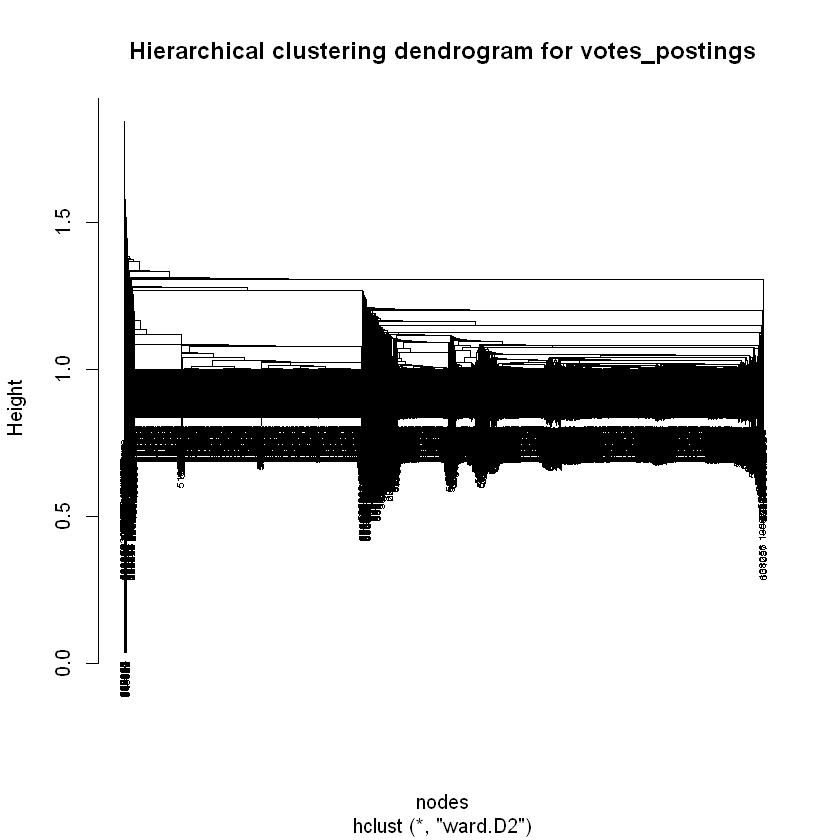

[1] "Graph type 'votes_postings': All attempts result in low average silhouette widths. No meaningful clustering result."


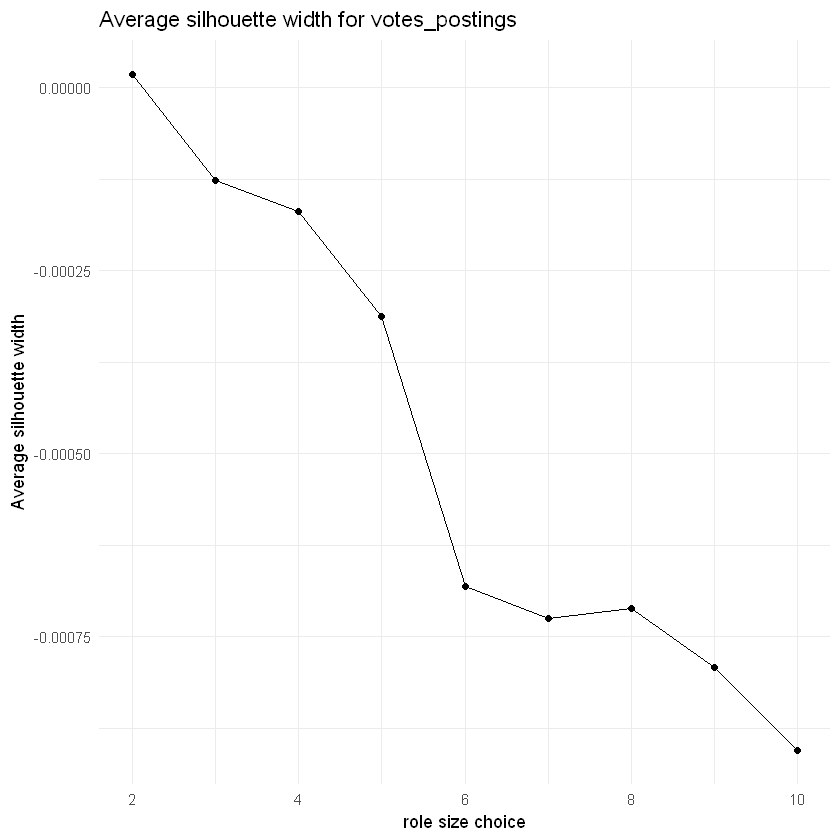

In [61]:
# types <- c("postings_replies", "votes_postings_unweighted", "votes_postings")
types <- c("votes_postings")
sims <- list()

for (type in types) {
  # sims[[type]] <- read_parquet(paste0("results/simrank/sr_",type,".parquet"))
  sims[[type]] <- read_parquet("C:/tmp/equivalence-based-network-role-mining/results/simrank/sr_votes_postings.parquet")
  sims[[type]] <- sims[[type]] %>% select(-last_col())
}

clustering(sims, types, "simrank")	

### RoleSim

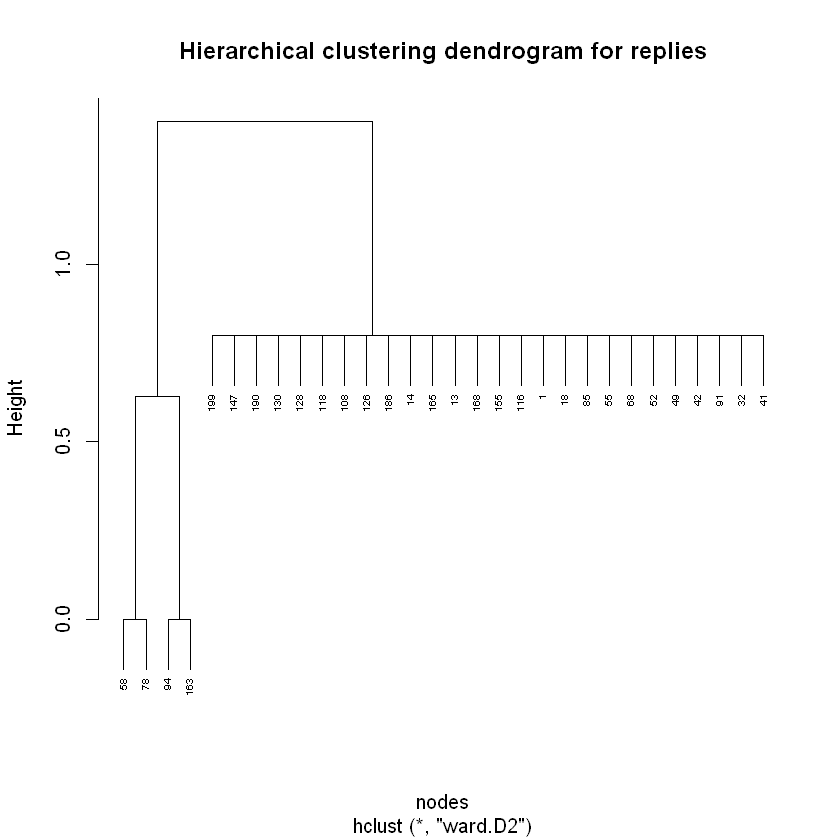

[1] "Graph type 'replies': All attempts result in low average silhouette widths. No meaningful clustering result."


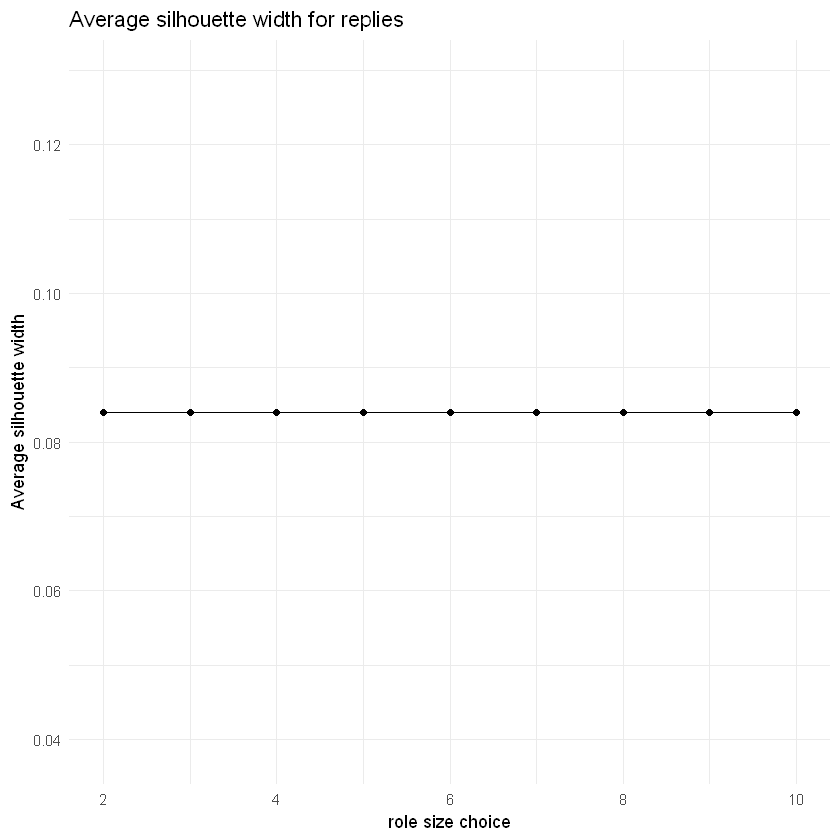

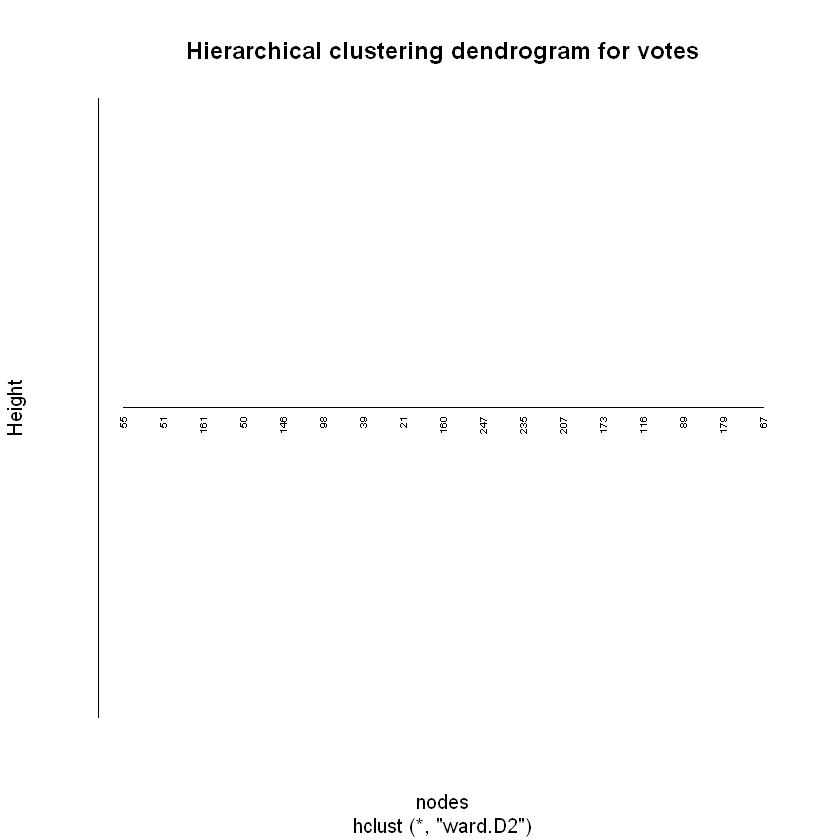

[1] "Graph type 'votes': All attempts result in low average silhouette widths. No meaningful clustering result."


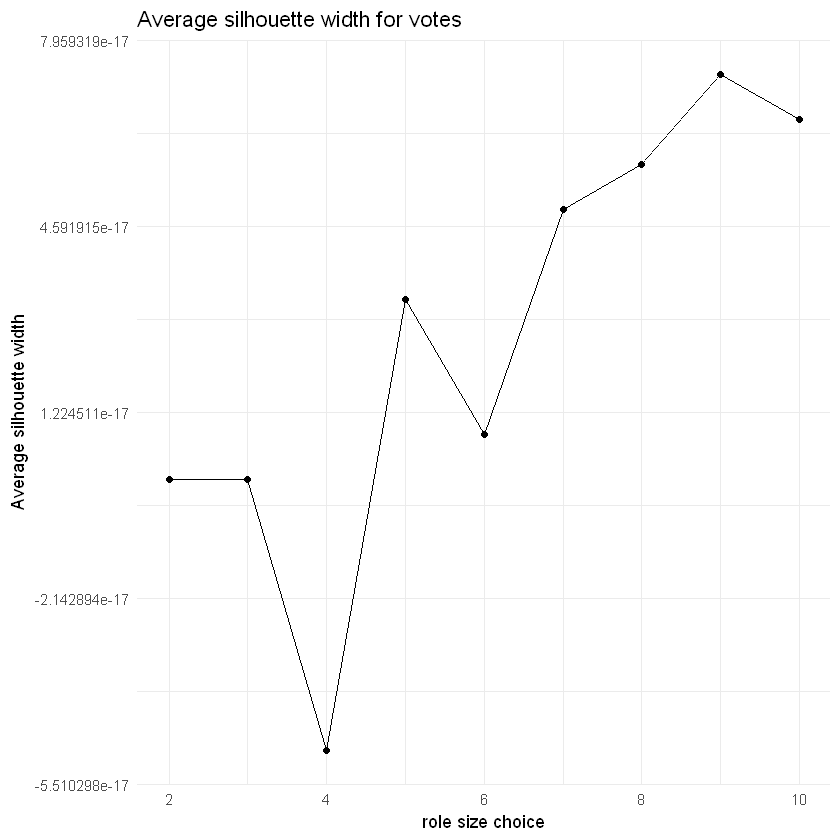

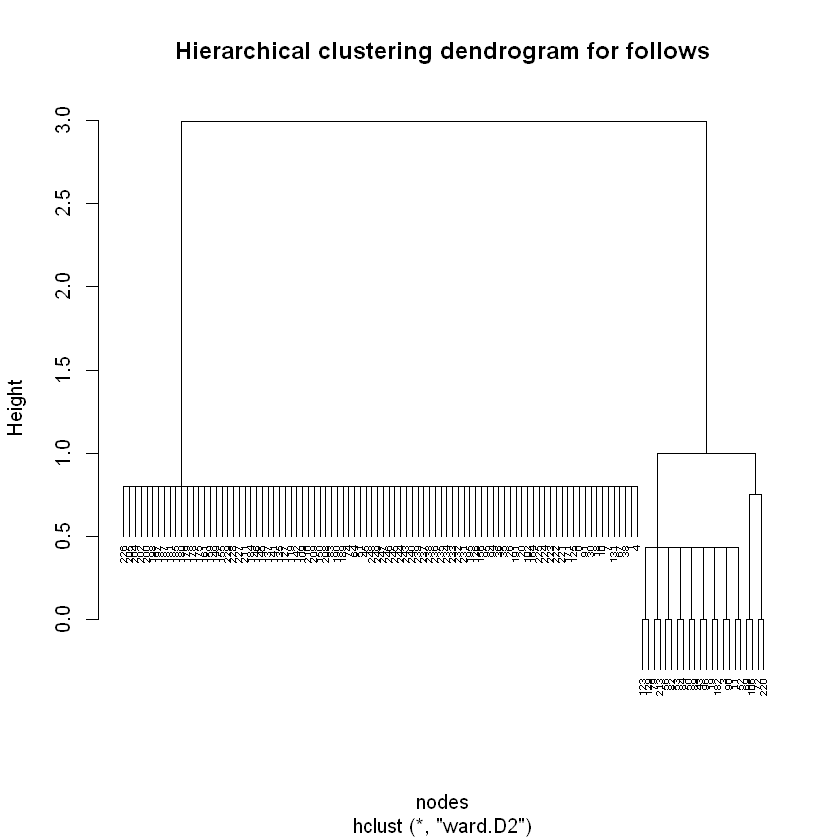

[1] "Graph type 'follows': All attempts result in low average silhouette widths. No meaningful clustering result."


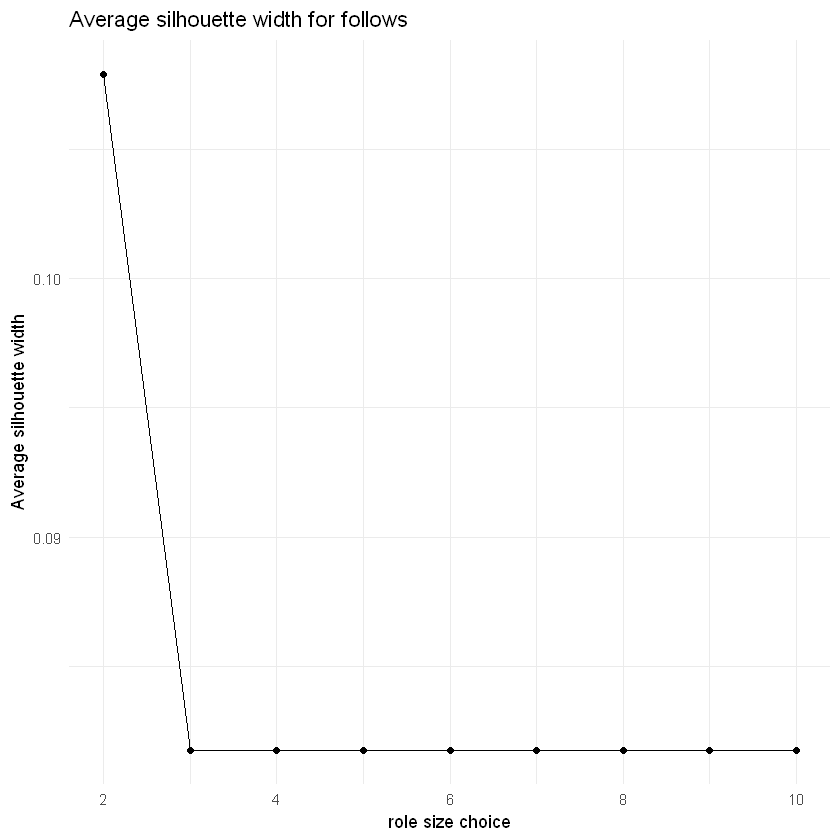

In [53]:
types <- c("replies", "votes", "follows")
sims <- list()
n_rolesim <- 253

for (type in types) {
  m <- read_csv(paste0("results/rolesim/",type,"-",n_rolesim,"-dissimilarity-matrix.csv"), show_col_types = FALSE, name_repair = "unique_quiet") 
  sims[[type]] <- m %>% column_to_rownames(var = colnames(m)[1])
}

clustering(sims, types, "rolesim")

### REGE

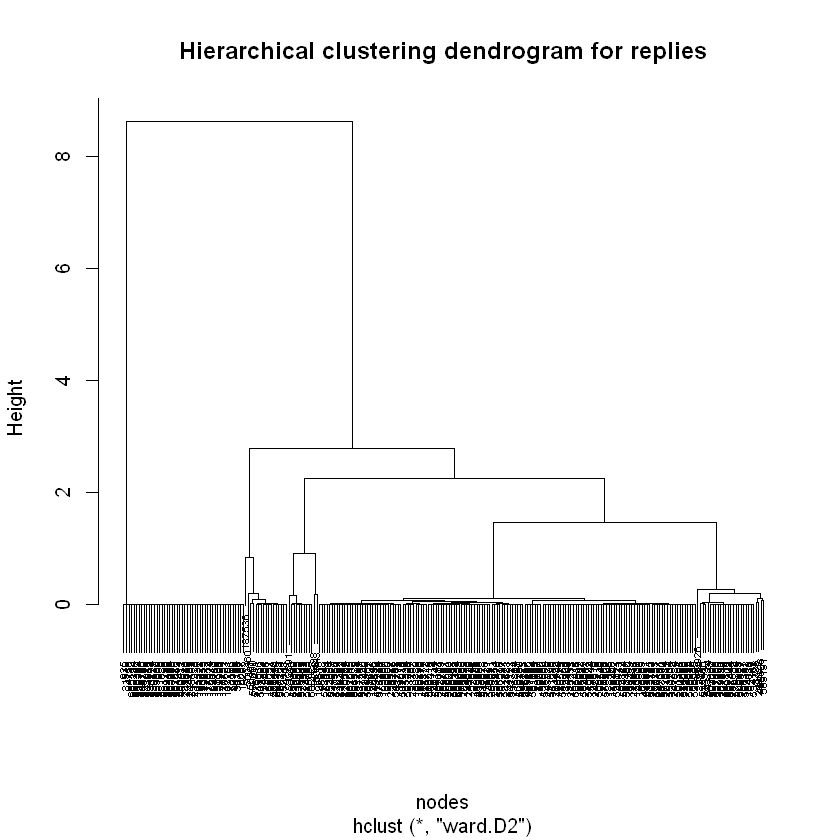

[1] "Graph type 'replies': Best average silhouette width at cluster number k=7"


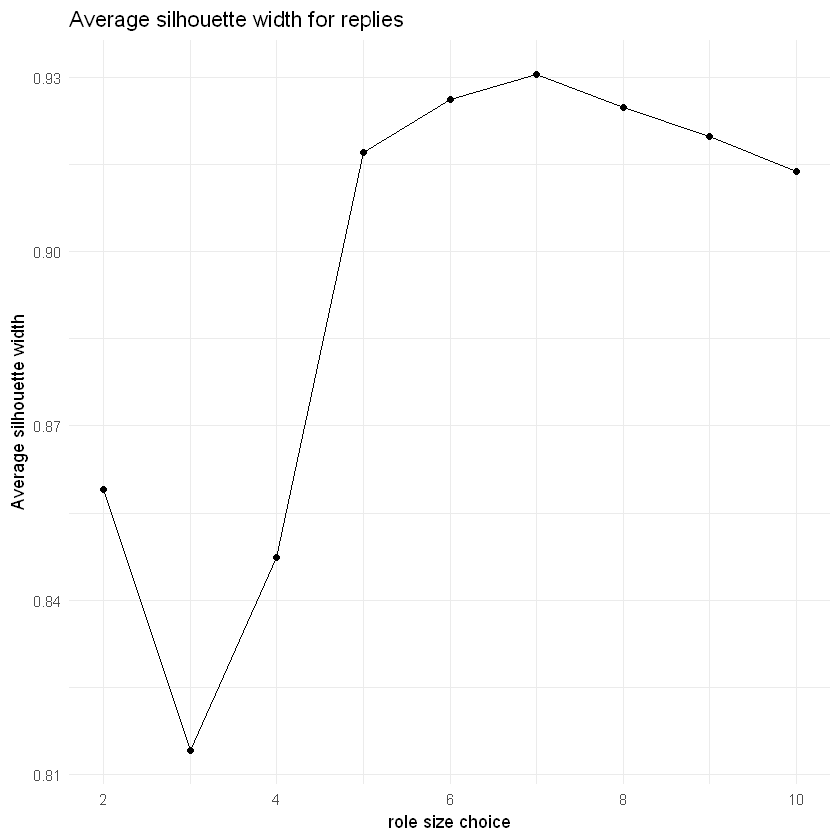

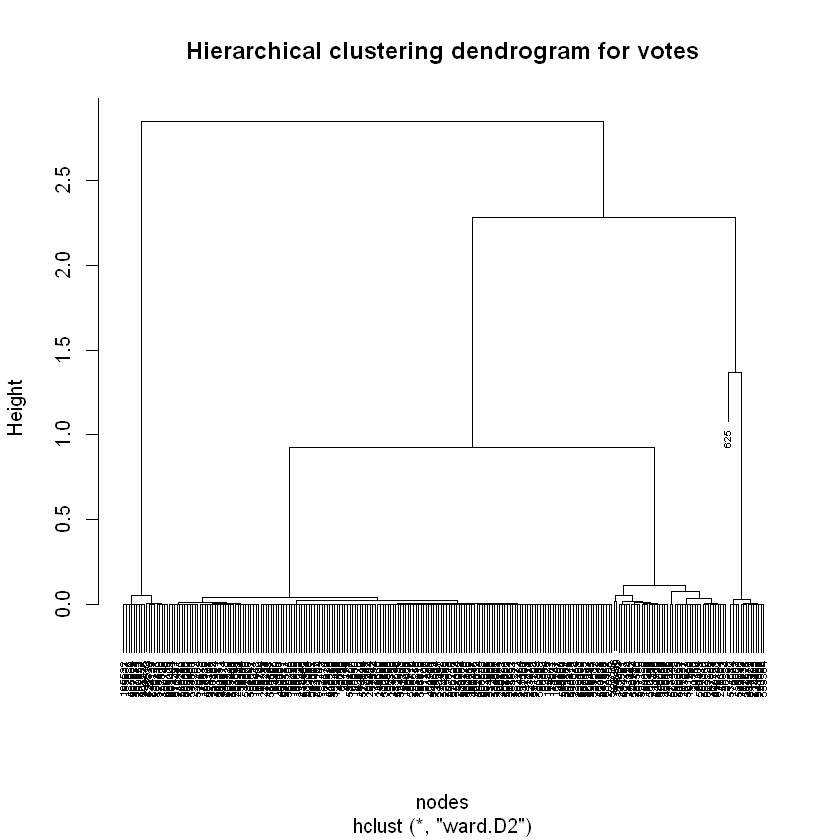

[1] "Graph type 'votes': Best average silhouette width at cluster number k=5"


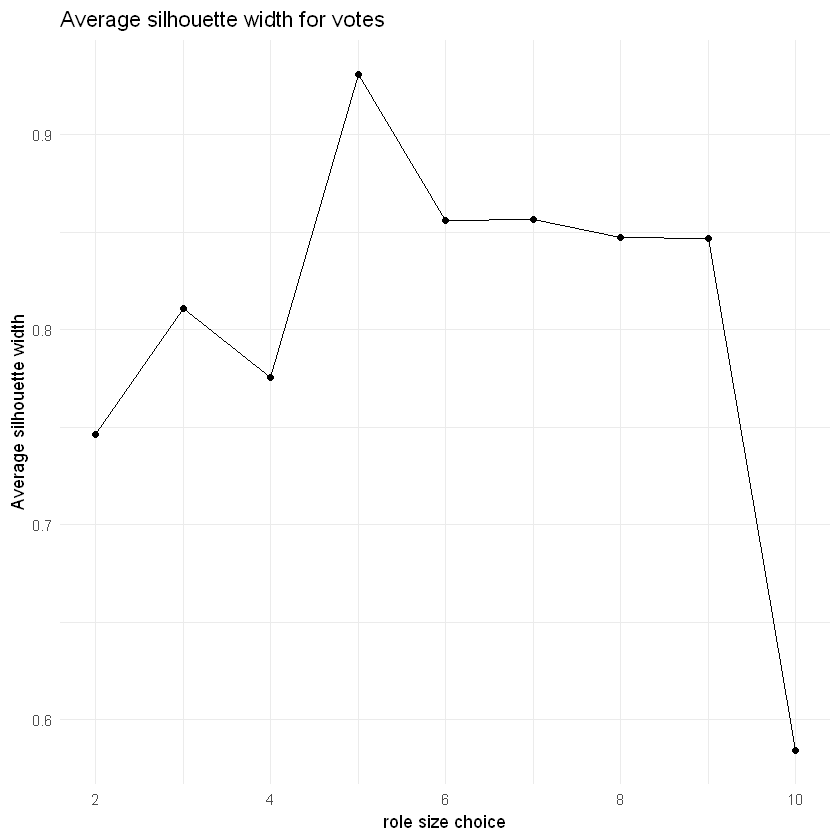

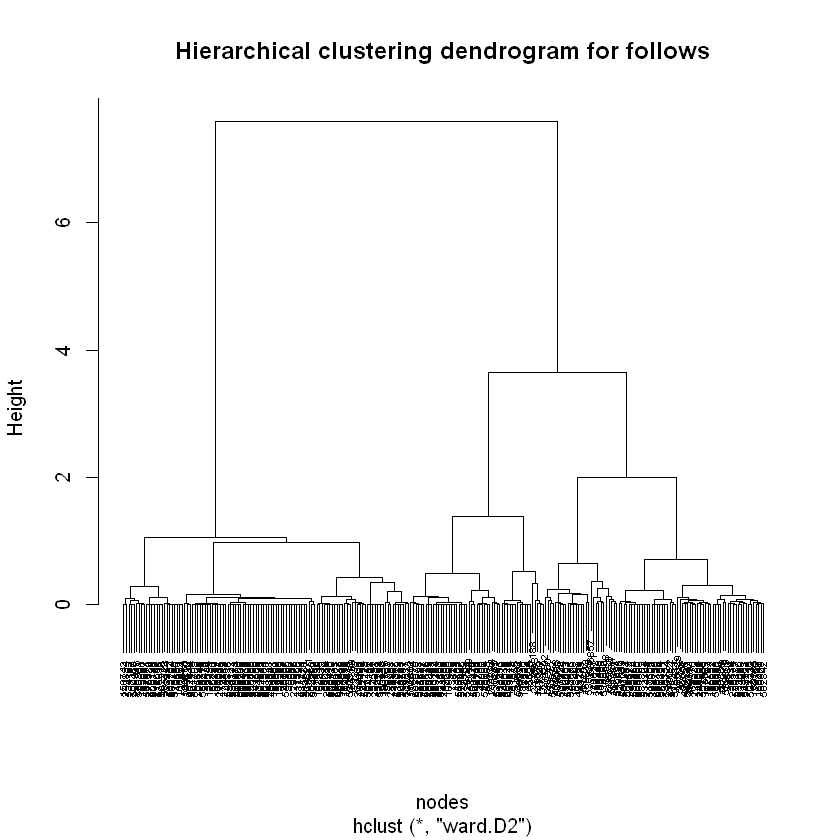

[1] "Graph type 'follows': Best average silhouette width at cluster number k=5"
  node_id group group_replies group_votes group_follows
1    6007 1_1_5             1           1             5
2   14285 1_2_1             1           2             1
3   18786 2_2_1             2           2             1
4   24561 3_2_5             3           2             5
5   26146 4_2_5             4           2             5
6   28707 4_2_5             4           2             5


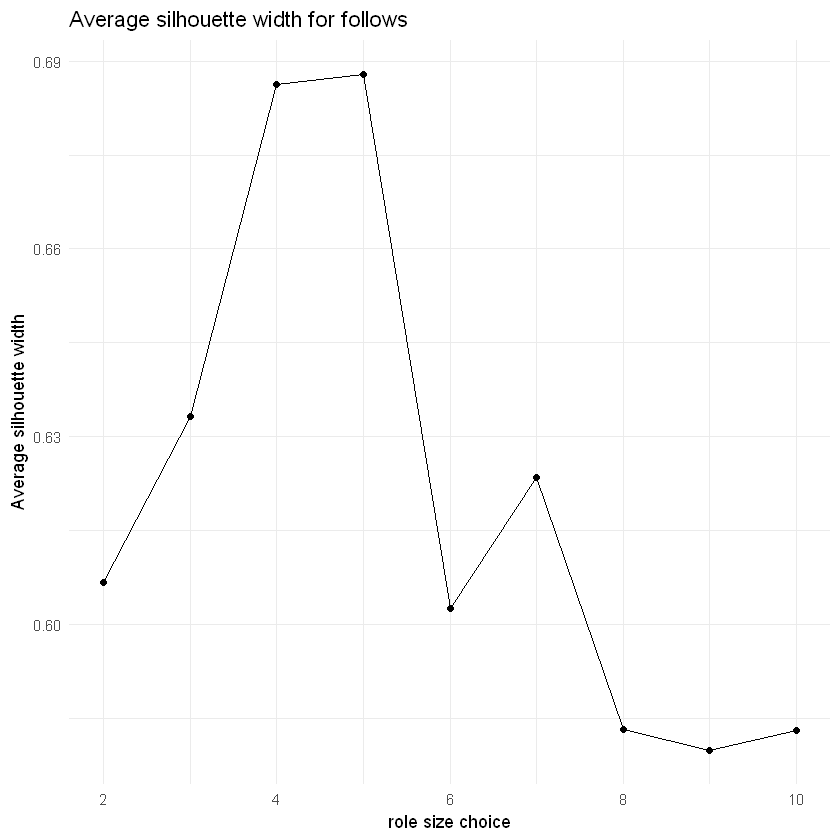

In [62]:
types <- c("replies", "votes", "follows")
sims <- list()
n_rege <- 253

for (type in types) {
  regeoutput <- readRDS(paste0("results/rege/rege-",type,"-",n,".rds"))
  sims[[type]] <- regeoutput[[type]]
}

clustering(sims, types, "rege")	